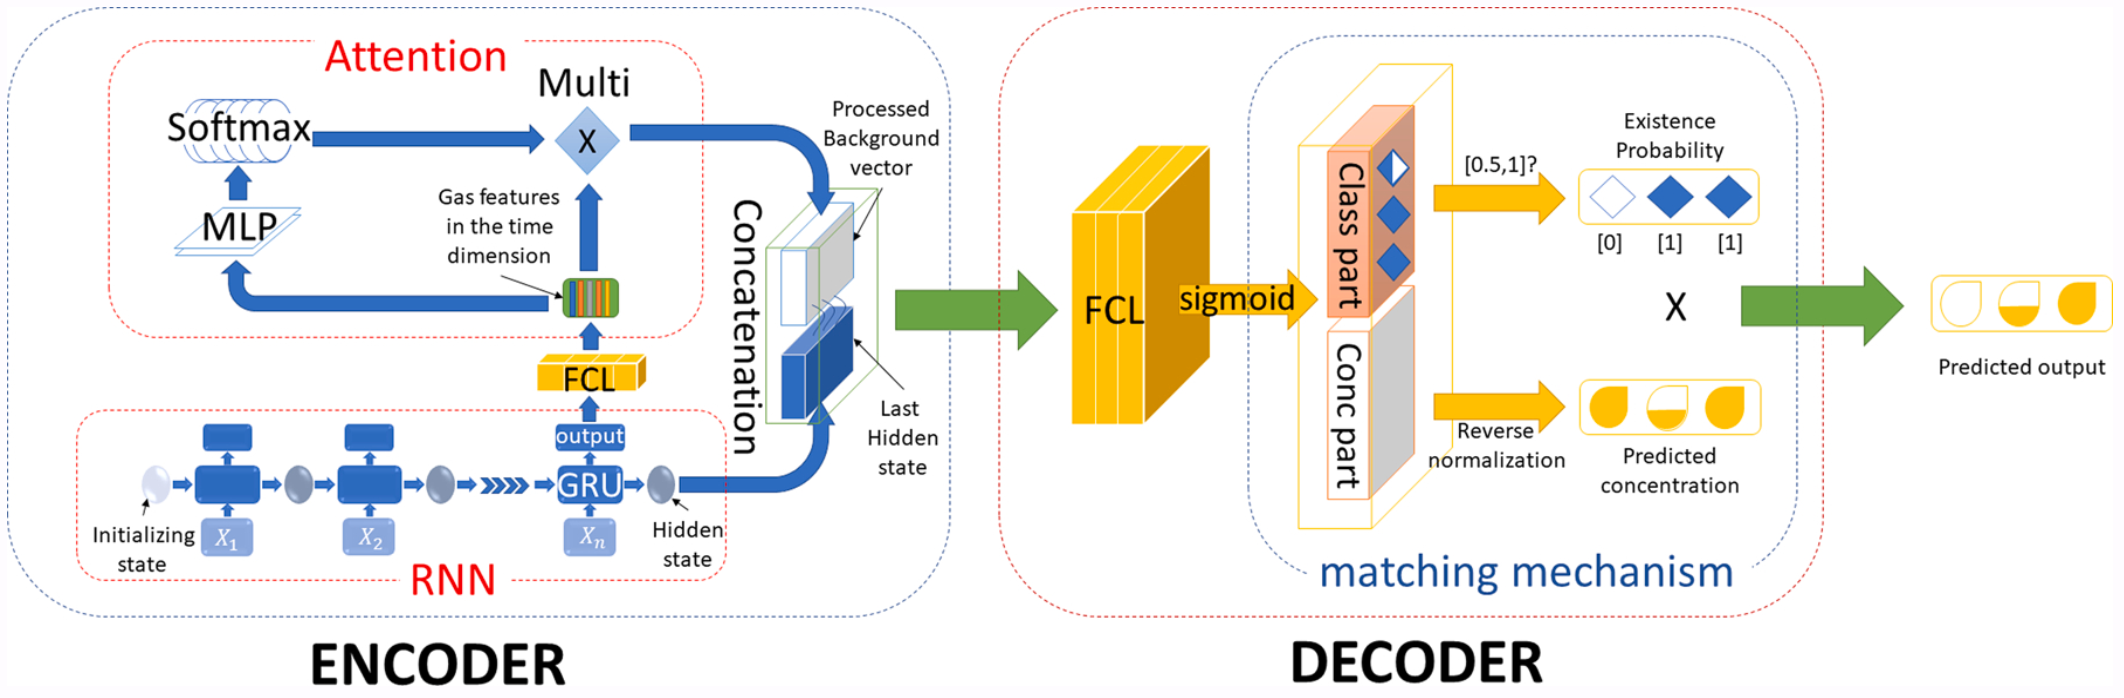

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
import torch.utils.data as Data
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from torch.nn import BCEWithLogitsLoss, BCELoss, MultiLabelSoftMarginLoss
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2
import scipy.stats as st
import sys
sys.path.append(r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\多组分气体识别与浓度检测\数据集\HITRAN_dataset\实验")
from utils import array_to_tensor, Data_set, model, hamming_score, predict
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
import seaborn as sns

# Encoder implementation

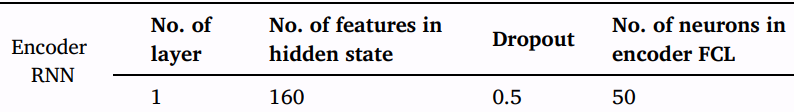

In [2]:
class EncoderRnn(nn.Module):
    
    def __init__(self, input_size, hidden_size, fc_size, dropout):
        super(EncoderRnn, self).__init__()
        # encoder hidden size = 160
        # encoder dropout = 0.5
        # number of neurons in encoder = 50
        self.dropout = nn.Dropout(dropout)
        self.hidden_size = hidden_size
        self.GRU = nn.GRU(input_size, hidden_size)
        self.FC = nn.Linear(hidden_size, fc_size)
    
    def forward(self, x):
        # x = (batch, seq_len)
        x = x.unsqueeze(2).permute(1, 0 ,2)
        # x = (seq_len, batch, 1)
        x, hidden = self.GRU(x)
        # x = (seq_len, batch, hidden_size)
        # hidden = (1, batch, hidden_size)
        x = self.dropout(x)
        output = torch.tanh(self.FC(x))
        
        return output, x, hidden

### 测试一下

In [3]:
x = torch.randn(10, 3321)
encoder = EncoderRnn(1, 160, 50, 0.5)
output, x, hidden = encoder(x)
print(output.shape)
print(x.shape)
print(hidden.shape)

torch.Size([3321, 10, 50])
torch.Size([3321, 10, 160])
torch.Size([1, 10, 160])


# Attention Implementation

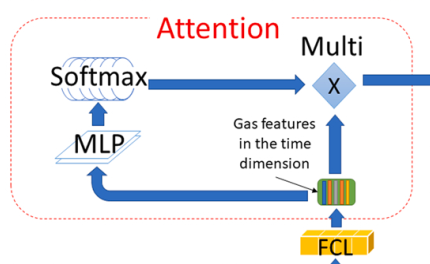

In [4]:
class Attention(nn.Module):
    
    def __init__(self, encoder_output_size, encoder_hidden_size, attention_size):
        super().__init__()
        self.attn = nn.Linear(encoder_output_size + encoder_hidden_size, attention_size)
        self.v = nn.Linear(attention_size, 1, bias=False)
    
    def forward(self, encoder_outputs, hiddens):
        # encoder_outputs = (seq_len, batch, 50)
        # hiddens = (seq_len, batch, 160)
        batch_size = hiddens.shape[0]
        seq_len = encoder_outputs.shape[0]
        
        hiddens = hiddens.permute(1, 0, 2)
        # hiddens = (batch, seq_len, 160)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # (batch, seq_len, 50)
        energy = torch.tanh(self.attn(torch.cat((encoder_outputs, hiddens), dim=2)))
        # batch, seq_len, attention_size
        attention = self.v(energy).squeeze()
        # (batch, seq_len, 1)
        weights = F.softmax(attention, dim=1)
        weights = weights.unsqueeze(1)
        # (batch, 1, seq_len)
        context = torch.bmm(weights, encoder_outputs).squeeze()
        # context = (batch, 50)
        
        # return weights
        return context
        

### 测试一下

In [5]:
x = torch.randn(3321, 10, 50)
hiddens = torch.randn(3321, 10, 160)
attention = Attention(50, 160, 128)
w = attention(x, hiddens)
print(w.shape)

torch.Size([10, 50])


# The whole Encoder Implementation

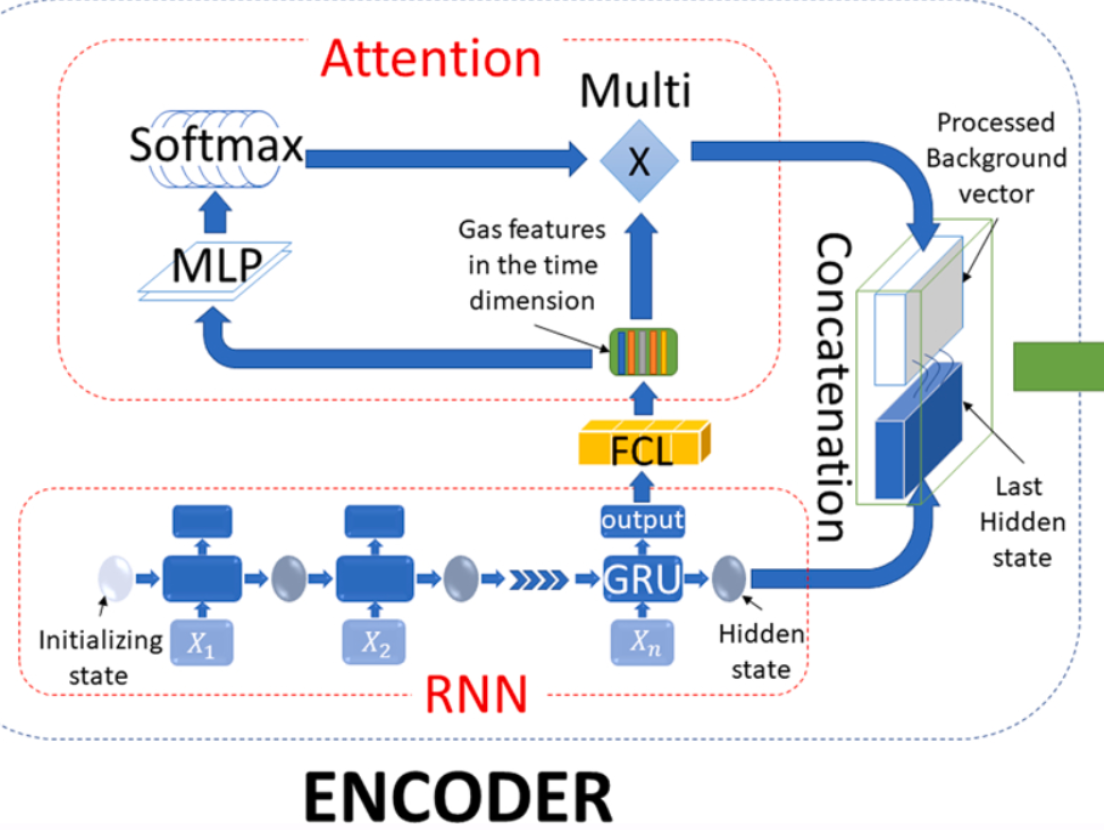

In [6]:
class Encoder(nn.Module):
    
    def __init__(self, encoderrnn, attention):
        super().__init__()
        self.encoderrnn = encoderrnn
        self.attention = attention
        
    def forward(self, x):
        output, x, hidden = encoderrnn(x)
        hidden = hidden.squeeze()
        context = self.attention(output, x)
        concatenation = torch.cat((context, hidden), dim=1)
        
        return concatenation

### 测试一下

In [7]:
x = torch.randn(10, 3321)
encoderrnn = EncoderRnn(1, 160, 50, 0.5)
attention = Attention(50, 160, 128)
encoder = Encoder(encoderrnn, attention)
concatenation = encoder(x)
print(concatenation.shape)

torch.Size([10, 210])


# Decoder Implementation

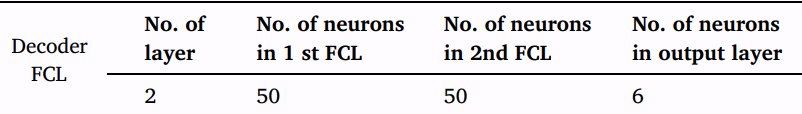

In [8]:
class Decoder(nn.Module):
    
    def __init__(self, decoder_fc1_size, decoder_fc2_size):
        super().__init__()
        self.decoder_fc1 = nn.Linear(210, decoder_fc1_size)
        self.decoder_fc2 = nn.Linear(decoder_fc1_size, decoder_fc2_size)
        self.decoder_fc3 = nn.Linear(decoder_fc2_size, 6)
    
    def forward(self, x):
        out = self.decoder_fc1(x)
        out = self.decoder_fc2(out)
        out = self.decoder_fc3(out)
        return out

### 测试一下

In [9]:
decoder = Decoder(50, 50)
print(concatenation.shape)
out = decoder(concatenation)
print(out.shape)

torch.Size([10, 210])
torch.Size([10, 6])


# Implementation of the Whole 2L-ARNN

In [10]:
class ARNN(nn.Module):
    def __init__(self, Encoder, Decoder):
        super().__init__()
        self.encoder = Encoder
        self.decoder = Decoder
    def forward(self, x):
        concatenation = self.encoder(x)
        out = self.decoder(concatenation)
        return out

### 测试一下

In [11]:
encoderrnn = EncoderRnn(1, 160, 50, 0.5)
attention = Attention(50, 160, 128)
encoder = Encoder(encoderrnn, attention)
decoder = Decoder(50, 50)
arnn = ARNN(encoder, decoder)

In [12]:
x = torch.randn(100, 1111) # 1111 sampling point的 100个input spectra
out = arnn(x)              # 100个输出维度为6的prediction
print(out.shape)

torch.Size([100, 6])


### Training parameters

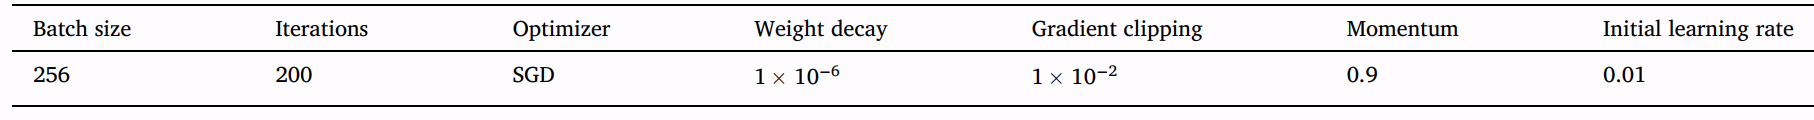

In [13]:
# device = torch.device("cuda")
# encoderrnn = EncoderRnn(1, 160, 50, 0.5).to(device)
# attention = Attention(50, 160, 128).to(device)
# encoder = Encoder(encoderrnn, attention).to(device)
# decoder = Decoder(50, 50).to(device)
# arnn = ARNN(encoder, decoder).to(device)

In [14]:
path1 = r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\多组分气体识别与浓度检测\数据集\HITRAN_dataset\实验\甲烷、丙酮、水数据库\数据集\混合气体吸收光谱\input.npy"
path2 = r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\多组分气体识别与浓度检测\数据集\HITRAN_dataset\实验\甲烷、丙酮、水数据库\数据集\混合气体吸收光谱\label.npy"
blended_spectra = np.load(path1)
label = np.load(path2)
inputs = torch.from_numpy(blended_spectra).type(torch.float32)
outputs = torch.from_numpy(label).type(torch.float32)
outputs[:, 3:5] = outputs[:, 3:5]/50
outputs[:, 5] = outputs[:, 5] / 2000

In [15]:
optimizer = torch.optim.SGD(arnn.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6)
criterion2 = nn.MSELoss()
criterion1 = nn.BCEWithLogitsLoss()
clip = 1e-2
epochs = 200
batch_size = 256
data_set = Data.TensorDataset(inputs, outputs)
data_loader = Data.DataLoader(dataset=data_set,
                              shuffle=True,
                              batch_size=batch_size,
                              num_workers=0)

In [16]:
loss_list = []
classification_loss = []
regression_loss = []
for e in range(epochs):
    arnn.train()
    for _, (batch_x, batch_y) in enumerate(data_loader):
        optimizer.zero_grad()
        # print(batch_x.shape)   
        prediction = arnn(batch_x)
        loss1 = criterion1(prediction[:, :3], batch_y[:, :3])
        classification_loss.append(float(loss1))
        loss2 = torch.sqrt(criterion2(prediction[:, 3:], batch_y[:, 3:]))
        # RMSE loss refer to the original paper
        regression_loss.append(float(loss2))
        loss = loss1 + loss2
        loss_list.append(float(loss))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(arnn.parameters(), clip)
        optimizer.step()
        print(loss.item())

0.7112194299697876
0.709803581237793
0.7307177186012268
0.7114001512527466
0.6863081455230713
0.7336536049842834
0.7015808820724487
0.7215492725372314
0.7191400527954102
0.7019602060317993
0.6918660402297974
0.69026780128479
0.7214860320091248
0.7141507863998413
0.7018033266067505
0.6764898896217346
0.71055006980896
0.6939311027526855
0.7284444570541382
0.7386128306388855
0.7051984667778015
0.7066948413848877
0.704601526260376
0.7074995040893555
0.6693764328956604
0.6998568773269653
0.7011556625366211
0.7088948488235474
0.6911196708679199
0.7010847330093384
0.7109202146530151
0.7272701263427734
0.7185251116752625
0.7220191359519958
0.6874532699584961
0.7323942184448242
0.6691399812698364
0.6903179883956909
0.7165087461471558
0.6905615329742432
0.7072358727455139
0.7000000476837158
0.6995863914489746
0.7186673879623413
0.7142562866210938
0.702631950378418
0.7067630290985107
0.7095819711685181
0.7418127655982971
0.6978226900100708
0.6813511848449707
0.688694953918457
0.6991965770721436
0

KeyboardInterrupt: 

D:\PYHTON\python3.7\DeepLearningProgram\Lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\PYHTON\python3.7\DeepLearningProgram\Lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


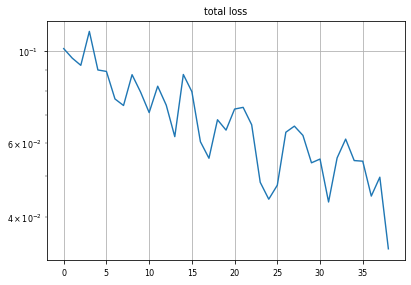

D:\PYHTON\python3.7\DeepLearningProgram\Lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\PYHTON\python3.7\DeepLearningProgram\Lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


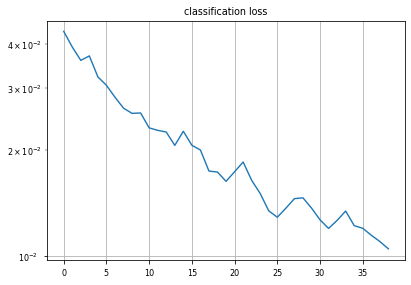

D:\PYHTON\python3.7\DeepLearningProgram\Lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\PYHTON\python3.7\DeepLearningProgram\Lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


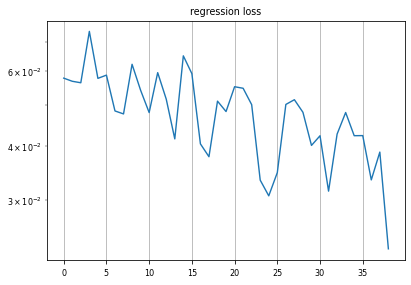

In [25]:
loss_list = np.array(loss_list)

Loss = []
for i in range(epochs):
    Loss.append(np.mean(loss_list[i*80: (i+1)*80]))
Loss = np.array(Loss)


plt.figure()
plt.grid()
plt.yscale("log")
plt.plot(Loss)
plt.title("total loss")
plt.show()

Loss = []
for i in range(epochs):
    Loss.append(np.mean(classification_loss[i*80: (i+1)*80]))
Loss = np.array(Loss)

plt.figure()
plt.style.use('seaborn-paper')
plt.grid()
plt.yscale("log")
plt.plot(Loss)
plt.title("classification loss")
plt.show()

Loss = []
for i in range(epochs):
    Loss.append(np.mean(regression_loss[i*80: (i+1)*80]))
Loss = np.array(Loss)

plt.figure()
plt.style.use('seaborn-paper')
plt.grid()
plt.yscale("log")
plt.title("regression loss")
plt.plot(Loss)
plt.show()

### save model

In [24]:
# path = r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\多组分气体识别与浓度检测\数据集\HITRAN_dataset\实验\模型保存\2larnn.pt"
# torch.save(arnn.state_dict(), path)

### load model

In [22]:
path = r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\多组分气体识别与浓度检测\数据集\HITRAN_dataset\实验\模型保存\2larnn.pt"
arnn.load_state_dict(torch.load(path))

<All keys matched successfully>

In [23]:
loss_list = []
classification_loss = []
regression_loss = []
for e in range(epochs):
    print("epoch: {}".format(e))
    arnn.train()
    for _, (batch_x, batch_y) in enumerate(data_loader):
        optimizer.zero_grad()
        # print(batch_x.shape)   
        prediction = arnn(batch_x)
        loss1 = criterion1(prediction[:, :3], batch_y[:, :3])
        classification_loss.append(float(loss1))
        loss2 = torch.sqrt(criterion2(prediction[:, 3:], batch_y[:, 3:]))
        # RMSE loss refer to the original paper
        regression_loss.append(float(loss2))
        loss = loss1 + loss2
        loss_list.append(float(loss))
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(arnn.parameters(), clip)
        optimizer.step()
        print(loss.item())

epoch: 0
0.10664217174053192
0.10987525433301926
0.10275901854038239
0.12094935774803162
0.0923742726445198
0.11179710924625397
0.0983022153377533
0.10546126961708069
0.10004977881908417
0.0981384664773941
0.1130579486489296
0.10281218588352203
0.09936140477657318
0.09631553292274475
0.0992184430360794
0.10646158456802368
0.09554726630449295
0.10744936764240265
0.10784954577684402
0.10506746172904968
0.10216136276721954
0.09799874573945999
0.0907185897231102
0.09216724336147308
0.11295442283153534
0.10081825405359268
0.10277041792869568
0.10639326274394989
0.10465241968631744
0.09963268041610718
0.10184026509523392
0.0993325263261795
0.11551479995250702
0.09703409671783447
0.10879816114902496
0.10542307794094086
0.0994390994310379
0.10771630704402924
0.1101246178150177
0.10348758101463318
epoch: 1
0.1021108403801918
0.10033414512872696
0.12375622987747192
0.09653730690479279
0.09465457499027252
0.10716480016708374
0.10133081674575806
0.09510348737239838
0.10267579555511475
0.1012630760

KeyboardInterrupt: 